# NLP: Search Engine

In [1]:
from nltk.tokenize import word_tokenize
import sqlite3

conn = sqlite3.connect('news.db')
cur = conn.cursor()


def 어절(sentence, n=2):
    tokens = word_tokenize(sentence)
    return [
        tuple(tokens[token:token + n])
        for token in range(len(tokens) - (n - 1))
    ]


def 음절(sentence, n=2):
    tokens = list(sentence)
    return [''.join(tokens[i:i + n]) for i in range(len(tokens))]

In [2]:
query = """
    SELECT id, url, content, date
    FROM news;
"""
cur.execute(query)
corpus = cur.fetchall()
corpus = [news[2] for news in corpus]

---

In [3]:
import re
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
pattern1 = re.compile(f'{re.escape(punctuation)}')
pattern2 = re.compile(r'[A-Za-z]{5,}')
pattern3 = re.compile(r'[^ 0-9A-Za-z가-힣]')
pattern4 = re.compile(r'\n{2,}')

In [5]:
collection = [
    pattern4.sub('',
                 pattern3.sub('',
                              pattern2.sub('',
                                           pattern1.sub('', _)))).strip()
    for _ in corpus
]

- Tokenizer (어절, 형태소, ngram)
- ngram: Stemming / Normalization (길이, 빈도) --> stopwording

In [6]:
len(word_tokenize(collection[0])), len(collection[0].split())

(515, 515)

In [7]:
len(collection[0].split()), len(어절(collection[0])), len(음절(collection[0]))

(515, 514, 2146)

In [8]:
from konlpy.tag import Kkma
kkma = Kkma()

C:\Users\u\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
Vocabulary = []

for _ in collection:
    Vocabulary.extend(_.split())
    Vocabulary.extend(어절(_))
    Vocabulary.extend(음절(_))
    Vocabulary.extend(kkma.morphs(_))

In [10]:
len(Vocabulary), len(set(Vocabulary))

(110740, 28262)

In [11]:
Vocabulary = [_ for _ in list(set(Vocabulary)) if 1 < len(_) < 6]

In [12]:
len(Vocabulary)

26849

In [13]:
BoM = []
for d in collection:
    docVector = [0 for _ in range(len(Vocabulary))]
    BoMCollection = d.split() + 어절(d) + 음절(d) + kkma.morphs(d)
    for _ in BoMCollection:
        if _ in Vocabulary:
            docVector[Vocabulary.index(_)] = 1
    BoM.append(docVector)

BoM의 문제점은 Sparse하다 (복잡도가 증가한다)

In [14]:
[(sum(_), len(Vocabulary) - sum(_)) for _ in BoM]

[(1753, 25096),
 (1753, 25096),
 (1156, 25693),
 (1321, 25528),
 (1745, 25104),
 (1451, 25398),
 (625, 26224),
 (1073, 25776),
 (1387, 25462),
 (1195, 25654),
 (1690, 25159),
 (2229, 24620),
 (1545, 25304),
 (1137, 25712),
 (1825, 25024),
 (1969, 24880),
 (1070, 25779),
 (1089, 25760),
 (933, 25916),
 (1030, 25819),
 (1433, 25416),
 (1274, 25575),
 (1612, 25237),
 (572, 26277),
 (1311, 25538),
 (1359, 25490),
 (1312, 25537),
 (1507, 25342),
 (1644, 25205),
 (976, 25873),
 (1844, 25005),
 (1774, 25075),
 (1074, 25775),
 (945, 25904),
 (848, 26001),
 (635, 26214)]

In [15]:
Query = ['대통령', '청와대']
totalResult = []
for q in Query:
    searchResult = []
    for i, d in enumerate(BoM):
        for j, b in enumerate(d):
            if b == 1 and j == Vocabulary.index(q):
                searchResult.append(i)
                break
    totalResult.append(searchResult)

In [16]:
set(totalResult[0]).intersection(totalResult[1])

{0, 1, 30}

## DTM & TDM

밑의 코드처럼 DTM과 TDM으로 자료구조를 만들어 놓으면 loop를 줄일 수 있다.

In [17]:
from collections import defaultdict

DTM = defaultdict(lambda: defaultdict(int))
for i, d in enumerate(BoM):
    for j, t in enumerate(d):
        if t == 1:
            DTM[i][j] = t

In [18]:
sum(DTM[0].values())

1753

In [19]:
TDM = defaultdict(lambda: defaultdict(int))

for i, termDict in DTM.items():
    for j, b in termDict.items():
        TDM[j][i] = b

In [20]:
searchResult = []
for q in Query:
    j = Vocabulary.index(q)
    searchResult.append(list(TDM[j].keys()))

In [21]:
set(totalResult[0]).intersection(totalResult[1])

{0, 1, 30}

### 성능 차이
Q = Query, D = Full Documents라고 했을 때,
- BoM = O(|Q| * D * |D|)
- TDM = O(|Q| * avg(|D|))

In [22]:
termVector = list(
    list(0 for _ in range(len(collection))) for _ in range(len(Vocabulary)))
for j, docDict in TDM.items():
    for i in range(len(collection)):
        termVector[j][i] = docDict[i]

In [23]:
import numpy as np
_BoM = np.array(termVector)

In [24]:
sum(_BoM.T[0])

1753

In [25]:
sum(BoM[0])

1753

In [26]:
_BoM[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = []

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = (j, 1, nextPosition)
        Dictionary[i] = len(Postings)
        Postings.append(_struct)

In [28]:
Dictionary

defaultdict(<function __main__.<lambda>()>, {0: 4, 1: 1, 2: 5, 3: 3})

In [29]:
Postings

[(0, 1, -1), (0, 1, -1), (1, 1, -1), (1, 1, -1), (2, 1, 0), (2, 1, 2)]

In [30]:
Q = ['C']

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        _struct = Postings[nextPosition]
        nextPosition = _struct[2]
        print(f'{_struct[0]+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break

3번째 문서, 1번, 다음 위치: 2
2번째 문서, 1번, 다음 위치: -1


---

posting된 데이터들을 파일로 저장한다.

In [31]:
D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'w')

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = (str(j), str(1), str(nextPosition))
        Dictionary[i] = Postings.tell()
        Postings.write(','.join(_struct) + '\n')
Postings.close()

In [32]:
Q = ['C']
Postings = open('postings.dst')

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        Postings.seek(nextPosition)
        _struct = Postings.readline().split(',')
        nextPosition = int(_struct[2])
        print(f'{int(_struct[0])+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break
Postings.close()

3번째 문서, 1번, 다음 위치: 16

2번째 문서, 1번, 다음 위치: -1



---

posting된 데이터들을 byte 형식으로 저장한다.
- https://docs.python.org/2/library/struct.html

In [33]:
from struct import pack

D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'wb')

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = pack('iii', j, 1, nextPosition)
        Dictionary[i] = Postings.tell()
        Postings.write(_struct)
Postings.close()

In [34]:
with open('postings.dst', 'rb') as fp:
    print(fp.read())

b'\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x01\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x01\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x18\x00\x00\x00'


In [35]:
from struct import unpack

Q = ['C']
Postings = open("postings.dst", 'rb')

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        Postings.seek(nextPosition)
        _struct = unpack("iii", Postings.read(4 * 3))
        nextPosition = int(_struct[2])
        print(f'{int(_struct[0])+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break
Postings.close()

3번째 문서, 1번, 다음 위치: 24
2번째 문서, 1번, 다음 위치: -1


In [36]:
D = [
    ['A', 'B'],
    ['C', 'D'],
    ['A', 'C'],
]

TDM = defaultdict(lambda: defaultdict(int))
Dictionary = defaultdict(lambda: -1)

V = list()
for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        TDM[i][j] = 1

In [37]:
Q = ['A', 'C']

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    for d, b in TDM[i].items():
        print(f'{d}번째 문서, {b}번')

0번째 문서, 1번
2번째 문서, 1번
1번째 문서, 1번
2번째 문서, 1번


## 자료구조에 빈도까지 포함하기

In [38]:
V = []
D = []

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        DTM[i][j] += 1

In [39]:
len(V), len(D)

(3165, 36)

In [40]:
TDM = defaultdict(lambda: defaultdict(int))

for i, terms in DTM.items():
    for j, f in terms.items():
        TDM[j][i] = f

In [41]:
# for j, docs in TDM.items():
#     for i, f in docs.items():
#         print(V[j], D[i], f)
#     print()

---

Posting해서 파일로 저장하는 방식

In [42]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = []

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = len(Postings)
        Postings.append(_struct)

In [43]:
for j, _ in enumerate(V):
    nextPosition = Dictionary[j]
    while True:
        _struct = Postings[nextPosition]
        nextPosition = _struct[2]
#         print(V[j], D[_struct[0]], _struct[1])

        if nextPosition == -1:
            break

---

In [44]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'w')

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = Postings.tell()
        Postings.write(f'{_struct[0]},{_struct[1]},{_struct[2]}\n')
Postings.close()

In [45]:
with open("postings.dst") as Postings:
    for j in range(len(V)):
        nextPosition = Dictionary[j]
        while True:
            Postings.seek(nextPosition)
            _struct = Postings.readline().split(',')
            nextPosition = int(_struct[2])
#             print(V[int(j)], D[int(_struct[0])], _struct[1])

            if nextPosition == -1:
                break

---

In [46]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'wb')

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = Postings.tell()
        Postings.write(pack('3i', i, f, nextPosition))
Postings.close()

In [47]:
with open("postings.dst", "rb") as Postings:
    for j in range(len(V)):
        nextPosition = Dictionary[j]
        while True:
            Postings.seek(nextPosition)
            _struct = unpack("3i", Postings.read(12))
            nextPosition = _struct[2]
            print(V[j], D[_struct[0]], _struct[1])
            if nextPosition == -1:
                break

고민 30 1
고민 26 1
고민 24 1
고민 15 1
고민 1 2
고민 0 2
정 33 1
정 30 1
정 29 1
정 24 8
정 22 1
정 14 1
정 10 3
정 9 2
정 6 5
정 4 1
정 3 1
정 2 1
정 1 2
정 0 2
청와대 30 2
청와대 7 1
청와대 2 1
청와대 1 9
청와대 0 9
대변인 30 2
대변인 1 6
대변인 0 6
뉴 24 1
뉴 21 1
뉴 20 6
뉴 8 2
뉴 1 1
뉴 0 1
시스 24 1
시스 21 1
시스 20 6
시스 8 2
시스 1 1
시스 0 1
17 35 1
17 34 1
17 33 1
17 32 2
17 31 2
17 30 1
17 25 1
17 24 1
17 23 1
17 22 1
17 21 1
17 20 3
17 19 1
17 18 1
17 17 1
17 16 2
17 15 1
17 14 1
17 12 1
17 10 2
17 9 3
17 8 3
17 7 3
17 5 3
17 4 1
17 3 2
17 2 3
17 1 1
17 0 1
일 35 1
일 34 1
일 33 1
일 32 2
일 31 10
일 30 7
일 29 1
일 28 10
일 27 3
일 26 5
일 25 1
일 24 3
일 23 1
일 22 2
일 21 2
일 20 12
일 19 2
일 18 2
일 17 1
일 16 6
일 15 1
일 14 2
일 13 2
일 12 1
일 11 4
일 10 9
일 9 3
일 8 7
일 7 3
일 6 3
일 5 3
일 4 1
일 3 7
일 2 4
일 1 9
일 0 9
한국 32 3
한국 31 8
한국 30 23
한국 28 13
한국 27 3
한국 23 2
한국 20 7
한국 19 3
한국 16 3
한국 15 1
한국 14 5
한국 13 3
한국 12 1
한국 10 5
한국 8 5
한국 7 3
한국 4 10
한국 2 9
한국 1 12
한국 0 12
겨냥 30 1
겨냥 28 1
겨냥 20 1
겨냥 1 1
겨냥 0 1
일본 31 12
일본 30 25
일본 28 18
일본 27 22
일본 26 1
일본 2

항의 10 2
항의 1 1
항의 0 1
뜻 25 1
뜻 24 1
뜻 23 1
뜻 8 1
뜻 1 1
뜻 0 1
표명 1 1
표명 0 1
책임 25 2
책임 24 1
책임 20 1
책임 18 2
책임 8 1
책임 1 1
책임 0 1
희망 19 1
희망 7 2
희망 2 1
희망 1 1
희망 0 1
도움 33 1
도움 24 2
도움 17 2
도움 2 1
도움 1 2
도움 0 2
편향 1 1
편향 0 1
자제 1 1
자제 0 1
경고 1 2
경고 0 2
메시지 1 1
메시지 0 1
논란 25 2
논란 23 2
논란 22 3
논란 21 2
논란 15 1
논란 8 4
논란 5 1
논란 1 1
논란 0 1
구설 22 1
구설 1 1
구설 0 1
포문 1 1
포문 0 1
이례적 11 1
이례적 6 1
이례적 1 1
이례적 0 1
실명 1 1
실명 0 1
구체적 30 1
구체적 25 1
구체적 1 1
구체적 0 1
배경 28 1
배경 11 1
배경 1 1
배경 0 1
균형 1 1
균형 0 1
감각 7 1
감각 1 1
감각 0 1
채 30 1
채 26 1
채 24 1
채 19 1
채 1 1
채 0 1
경제 35 7
경제 31 1
경제 30 2
경제 28 2
경제 27 2
경제 23 1
경제 14 4
경제 13 2
경제 12 1
경제 11 7
경제 7 5
경제 4 2
경제 1 1
경제 0 1
보복 30 1
보복 28 2
보복 27 3
보복 11 1
보복 1 1
보복 0 1
국면 1 1
국면 0 1
판단 31 1
판단 30 1
판단 28 1
판단 25 1
판단 14 1
판단 9 3
판단 8 8
판단 4 1
판단 1 1
판단 0 1
의미 15 1
의미 12 1
의미 4 1
의미 2 1
의미 1 1
의미 0 1
분석 31 2
분석 30 1
분석 29 1
분석 24 1
분석 17 1
분석 14 1
분석 12 3
분석 1 1
분석 0 1
핵심 33 1
핵심 32 1
핵심 31 2
핵심 25 2
핵심 11 1
핵심 1 1
핵심 0 1
관계자 33 1
관계자 23 1
관계자 15 3
관계자 1

금지 28 1
금지 26 1
금지 25 1
금지 24 1
금지 23 1
금지 21 1
금지 20 1
금지 18 1
금지 17 1
금지 16 1
금지 15 1
금지 14 1
금지 13 1
금지 12 1
금지 11 2
금지 10 1
금지 9 1
금지 8 1
금지 7 1
금지 6 1
금지 3 1
무협 4 10
통상 4 11
2020 4 2
수입 31 1
수입 25 1
수입 11 2
수입 4 2
대비 35 2
대비 31 4
대비 28 1
대비 14 2
대비 4 3
영주 18 1
영주 4 3
장기 17 1
장기 4 1
화시 4 1
대기업 15 2
대기업 4 2
소재 33 10
소재 31 4
소재 26 1
소재 4 4
부품 33 2
부품 31 2
부품 4 4
국산화 31 2
국산화 4 2
성진 4 1
미 30 3
미 27 4
미 22 2
미 14 8
미 11 4
미 7 2
미 4 3
무역 31 2
무역 30 3
무역 28 3
무역 27 12
무역 14 10
무역 11 8
무역 4 5
분쟁 31 1
분쟁 27 1
분쟁 14 8
분쟁 4 2
중국 31 3
중국 27 3
중국 14 5
중국 12 12
중국 11 22
중국 4 16
특성 14 1
특성 4 1
계속 32 1
계속 30 1
계속 24 2
계속 15 1
계속 4 1
장기화 4 3
전망 33 1
전망 31 2
전망 28 1
전망 25 1
전망 16 1
전망 15 3
전망 14 2
전망 12 2
전망 4 1
만큼 25 1
만큼 14 1
만큼 13 2
만큼 11 1
만큼 8 1
만큼 7 1
만큼 5 1
만큼 4 3
상수 4 1
두고 28 2
두고 9 2
두고 4 1
협회 4 1
제언 4 2
32 9 1
32 4 1
쪽 11 1
쪽 4 1
분량 33 2
분량 4 1
보고서 11 1
보고서 8 1
보고서 4 6
중간 22 1
중간 4 1
일정 34 1
일정 23 2
일정 20 1
일정 16 1
일정 13 1
일정 11 2
일정 10 11
일정 4 1
수준 35 1
수준 31 1
수준 15 1
수준 4 1
제기 28 1
제기 

의원 10 13
의원 8 18
총회 8 4
여의도 20 1
여의도 10 1
여의도 8 2
국회 34 4
국회 20 8
국회 16 6
국회 13 2
국회 10 4
국회 8 3
보건 34 1
보건 33 1
보건 8 1
복지 8 1
참석 31 2
참석 20 1
참석 8 2
순례 8 3
자유 30 1
자유 27 1
자유 20 5
자유 16 1
자유 14 1
자유 10 2
자유 8 4
승희 8 1
518 8 3
망언 8 3
징계 8 7
지도부 10 1
지도부 8 6
용인 8 1
개월 31 1
개월 17 1
개월 8 5
당원 8 7
정지 26 4
정지 8 4
최고 29 1
최고 14 1
최고 8 9
위원 15 1
위원 14 3
위원 8 6
자격 15 1
자격 8 3
18 31 1
18 28 2
18 20 1
18 14 1
18 10 1
18 9 1
18 8 1
직무 8 1
수행 8 1
회복 17 1
회복 12 1
회복 8 4
당헌 8 1
당규 8 1
상 34 3
상 31 1
상 28 1
상 25 1
상 8 1
박탈 8 3
행 8 1
법적 34 1
법적 20 1
법적 8 3
지도 8 4
부가 8 2
정치적 30 1
정치적 28 2
정치적 24 1
정치적 10 1
정치적 8 3
도외 8 1
시한 28 1
시한 8 1
회피 8 1
지적도 34 1
지적도 12 1
지적도 8 2
박 31 2
박 27 1
박 22 2
박 21 6
박 20 1
박 17 2
박 16 1
박 9 2
박 8 4
맹우 8 2
사무총장 8 4
법률 20 1
법률 8 1
의뢰 24 1
의뢰 21 1
의뢰 8 2
직 8 1
결론 11 2
결론 9 1
결론 8 1
황 22 1
황 8 3
교 31 1
교 27 1
교 8 2
자동 8 1
19 25 1
19 10 3
19 8 1
윤리 8 2
처분 8 1
당내 8 2
선거권 8 2
활동 29 2
활동 24 1
활동 9 2
활동 8 1
활동도 8 1
중단 27 2
중단 25 1
중단 11 1
중단 8 1
명시 10 1
명시 8 2
끝 26 1
끝 24 1
끝 8 1
고수

외 11 1
격 28 1
격 11 1
표정 22 1
표정 11 1
데니스 11 1
와일더 11 1
보좌관 11 1
지시 11 1
지지대 11 1
양 30 1
양 11 1
정상 28 1
정상 27 1
정상 11 1
한때 14 1
한때 11 1
폭탄 11 1
분기 32 1
분기 31 2
분기 14 1
분기 12 2
분기 11 1
성장률 14 1
성장률 12 1
성장률 11 1
62 12 1
62 11 1
전쟁 11 1
관영 11 1
인민 11 1
고율 11 1
가소 11 1
직격탄 11 1
꿀 12 1
꿀 11 1
잼 12 1
잼 11 1
청춘 12 1
청춘 11 1
스냅 12 1
스냅 11 1
미디어 32 7
미디어 12 1
미디어 11 1
아모레 12 6
퍼시픽 12 5
애경 12 3
올 32 2
올 31 1
올 29 2
올 12 1
25 24 1
25 20 2
25 18 1
25 12 1
급락 22 1
급락 12 3
화장품 12 24
저가 31 1
저가 12 3
브랜드 29 1
브랜드 12 11
가이 12 1
최정희 12 2
뷰티 12 2
우리나라 21 5
우리나라 12 5
090430 12 1
주의 33 1
주의 30 1
주의 27 1
주의 12 2
주가 20 1
주가 12 6
하락세 12 3
대중 12 2
입지 12 1
모양새 12 1
생활 12 6
건강 24 1
건강 22 3
건강 17 2
건강 15 1
건강 12 6
051900 12 1
중국인 12 4
선호 12 1
수혜 27 1
수혜 12 2
종목 12 1
옥석 12 1
가리기 12 1
마켓 12 2
포인트 30 4
포인트 15 1
포인트 14 1
포인트 12 2
감소 25 1
감소 19 1
감소 14 1
감소 12 4
002790 12 1
연초 12 2
238 12 1
202 12 1
252 12 1
하락 30 1
하락 14 1
하락 12 1
제조자 12 1
콜 12 1
마 12 2
161890 12 1
194 12 1
코스 14 2
코스 12 1
메카 12 1
코리아 31 4
코리아 21 9
코

밤 26 4
밤 25 3
밤 20 1
새벽 26 1
새벽 25 1
새벽 20 1
본관 20 1
몸싸움 20 1
행위 20 1
51 20 1
겸손 20 1
본연 20 1
봉쇄 20 1
제가 20 2
여기 20 1
인격 20 1
마지막 26 1
마지막 20 1
남 28 1
남 20 1
이배 20 1
국회법 20 1
수은 20 1
현직 24 1
현직 20 1
정의당 20 1
무소속 20 1
빅 20 1
데이터 20 1
시세표 20 1
공감 20 1
통신사 32 1
통신사 20 1
코르셋 21 3
한복 21 20
2019 25 1
2019 21 3
미스 21 9
대회 21 9
술 22 1
술 21 5
녀 21 5
연구가 34 1
연구가 21 1
최강 21 1
전통 25 1
전통 21 2
스타일 21 1
의류 21 2
문화 21 1
민족 21 1
옷 26 1
옷 21 7
현대적 21 1
눈살 21 1
대한민국 21 2
조상 21 1
후손 21 1
문화유산 21 2
다라 28 1
다라 25 1
다라 21 1
튜브 35 1
튜브 21 2
캡 21 2
고유성 21 1
고객 21 1
서양 21 1
드레스 21 1
입어 21 1
진행자 21 1
도전자 21 1
미인 21 2
세벌 21 1
농 21 1
뿌리 25 1
뿌리 21 1
동대문구 21 1
경희대 21 1
전당 21 1
수영복 21 2
여성 22 1
여성 21 1
상품화 21 2
주최 21 2
수용 21 1
고유 21 2
아름다움 21 1
수상자 21 1
가슴 21 1
허벅지 21 1
라인 21 1
재생산 21 1
정체성 21 1
훼손 21 1
결합 21 1
동서양 21 1
시대적 21 1
가미 21 1
우동 21 1
준규 21 1
생존 22 1
지환 22 2
대타 22 3
지석 22 1
낙점 22 1
도중 22 3
배우 22 8
교체 22 5
차례 22 1
하차 25 1
하차 22 14
제각각 22 2
연루 28 1
연루 22 1
사생활 22 1
시청자 22 2
당혹 22 1
혼란 22 1
제작자 22 1
마무리 32 

---

# TF-IDF
- [TF-IDF Wikipidia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [48]:
DTM = defaultdict(lambda: defaultdict(int))
for i, d in enumerate(BoM):
    for j, t in enumerate(d):
        if t == 1:
            DTM[i][j] = t

In [49]:
TDM = defaultdict(lambda: defaultdict(int))

for i, termDict in DTM.items():
    for j, b in termDict.items():
        TDM[j][i] = b

## TF
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Variants of term frequency (tf) weight
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>tf weight
</th></tr>
<tr>
<td>binary</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle {0,1}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mn>0</mn>
          <mo>,</mo>
          <mn>1</mn>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle {0,1}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a019735e07635e5a74673d6e1a34919027e645f5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:3.359ex; height:2.509ex;" alt="{0,1}"/></span>
</td></tr>
<tr>
<td>raw count</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/69faba5875c1ba7d6a3820c813ba22fba35185f5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:3.282ex; height:2.843ex;" alt="f_{{t,d}}"/></span>
</td></tr>
<tr>
<td>term frequency
</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}{\Bigg /}{\sum _{t'\in d}{f_{t',d}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mrow class="MJX-TeXAtom-ORD">
          <mrow class="MJX-TeXAtom-ORD">
            <mo fence="true" stretchy="true" symmetric="true" maxsize="2.470em" minsize="2.470em">/</mo>
          </mrow>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <munder>
            <mo>&#x2211;<!-- ∑ --></mo>
            <mrow class="MJX-TeXAtom-ORD">
              <msup>
                <mi>t</mi>
                <mo>&#x2032;</mo>
              </msup>
              <mo>&#x2208;<!-- ∈ --></mo>
              <mi>d</mi>
            </mrow>
          </munder>
          <mrow class="MJX-TeXAtom-ORD">
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <msup>
                  <mi>t</mi>
                  <mo>&#x2032;</mo>
                </msup>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
          </mrow>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}{\Bigg /}{\sum _{t'\in d}{f_{t',d}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/91699003abf4fe8bdf861bbce08e73e71acf5fd4" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -3.338ex; width:13.808ex; height:7.676ex;" alt="{\displaystyle f_{t,d}{\Bigg /}{\sum _{t&#039;\in d}{f_{t&#039;,d}}}}"/></span>
</td></tr>
<tr>
<td>log normalization</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log(1+f_{t,d})}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log(1+f_{t,d})}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9c173382612c58c00325c4e9f593739ab3afc324" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:12.066ex; height:3.009ex;" alt="\log(1+f_{{t,d}})"/></span>
</td></tr>
<tr>
<td>double normalization 0.5</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>0.5</mn>
        <mo>+</mo>
        <mn>0.5</mn>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
            <mrow>
              <munder>
                <mo movablelimits="true" form="prefix">max</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mo fence="false" stretchy="false">{</mo>
                  <msup>
                    <mi>t</mi>
                    <mo>&#x2032;</mo>
                  </msup>
                  <mo>&#x2208;<!-- ∈ --></mo>
                  <mi>d</mi>
                  <mo fence="false" stretchy="false">}</mo>
                </mrow>
              </munder>
              <mrow class="MJX-TeXAtom-ORD">
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>,</mo>
                    <mi>d</mi>
                  </mrow>
                </msub>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/45badc1c70ec2caa00ed8c21ed75bd9f8d3e650c" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.838ex; width:24.783ex; height:6.676ex;" alt="{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t&#039;\in d\}}{f_{t&#039;,d}}}}}"/></span>
</td></tr>
<tr>
<td>double normalization K</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>K</mi>
        <mo>+</mo>
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>&#x2212;<!-- − --></mo>
        <mi>K</mi>
        <mo stretchy="false">)</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
            <mrow>
              <munder>
                <mo movablelimits="true" form="prefix">max</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mo fence="false" stretchy="false">{</mo>
                  <msup>
                    <mi>t</mi>
                    <mo>&#x2032;</mo>
                  </msup>
                  <mo>&#x2208;<!-- ∈ --></mo>
                  <mi>d</mi>
                  <mo fence="false" stretchy="false">}</mo>
                </mrow>
              </munder>
              <mrow class="MJX-TeXAtom-ORD">
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>,</mo>
                    <mi>d</mi>
                  </mrow>
                </msub>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/65b776d7a3f8e42f15c880fb7582282b987684fe" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.838ex; width:27.105ex; height:6.676ex;" alt="{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t&#039;\in d\}}{f_{t&#039;,d}}}}}"/></span>
</td></tr></tbody></table>
</div>

In [50]:
from math import log


tf1 = lambda f, tf: f / tf                    # term frequency
tf2 = lambda f: log(1+f)                      # log normalization
tf3 = lambda f, mf, K=0.5: K + (1-K) * (f/mf) # double normalization K

In [51]:
tf1(1, 2), tf2(2), tf3(1, 2)

(0.5, 1.0986122886681098, 0.75)

In [52]:
for j, docs in TDM.items():
    for i, f in docs.items():
        TF1 = tf1(f, sum(DTM[i].values()))
        TF2 = tf2(f)
        TF3 = tf3(f, max(DTM[i].values()))
        print(V[j], i, TF1, TF2, TF3)
    break

규제 0 0.0005704506560182544 0.6931471805599453 1.0
규제 1 0.0005704506560182544 0.6931471805599453 1.0
규제 2 0.0008650519031141869 0.6931471805599453 1.0
규제 3 0.000757002271006813 0.6931471805599453 1.0
규제 4 0.0005730659025787965 0.6931471805599453 1.0
규제 5 0.0006891798759476223 0.6931471805599453 1.0
규제 6 0.0016 0.6931471805599453 1.0
규제 7 0.0009319664492078285 0.6931471805599453 1.0
규제 8 0.0007209805335255948 0.6931471805599453 1.0
규제 10 0.000591715976331361 0.6931471805599453 1.0
규제 11 0.00044863167339614175 0.6931471805599453 1.0
규제 14 0.000547945205479452 0.6931471805599453 1.0
규제 15 0.0005078720162519045 0.6931471805599453 1.0
규제 17 0.0009182736455463728 0.6931471805599453 1.0
규제 18 0.0010718113612004287 0.6931471805599453 1.0
규제 20 0.0006978367062107466 0.6931471805599453 1.0
규제 21 0.0007849293563579278 0.6931471805599453 1.0
규제 22 0.0006203473945409429 0.6931471805599453 1.0
규제 24 0.0007627765064836003 0.6931471805599453 1.0
규제 25 0.0007358351729212656 0.6931471805599453 1.0
규제 27 

## IDF
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Variants of inverse document frequency (idf) weight
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>idf weight (<span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle n_{t}=|\{d\in D:t\in d\}|}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>n</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
          </mrow>
        </msub>
        <mo>=</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">|</mo>
        </mrow>
        <mo fence="false" stretchy="false">{</mo>
        <mi>d</mi>
        <mo>&#x2208;<!-- ∈ --></mo>
        <mi>D</mi>
        <mo>:</mo>
        <mi>t</mi>
        <mo>&#x2208;<!-- ∈ --></mo>
        <mi>d</mi>
        <mo fence="false" stretchy="false">}</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">|</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle n_{t}=|\{d\in D:t\in d\}|}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e5d6fca54b5ec3fa4680ead41736fc1c16a58ca1" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:21.752ex; height:2.843ex;" alt="{\displaystyle n_{t}=|\{d\in D:t\in d\}|}"/></span>)
</th></tr>
<tr>
<td>unary</td>
<td>1
</td></tr>
<tr>
<td>inverse document frequency</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
        <mo>=</mo>
        <mo>&#x2212;<!-- − --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
            <mi>N</mi>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/864fcfdc0c16344c11509f724f1aa7081cf9f657" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:18.125ex; height:5.509ex;" alt="{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}"/></span>
</td></tr>
<tr>
<td>inverse document frequency smooth</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mfrac>
              <mi>N</mi>
              <mrow>
                <mn>1</mn>
                <mo>+</mo>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mrow>
            </mfrac>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/23e5ae785c1ddc6bd95d404ea3fac2477fff5eff" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:13.453ex; height:6.176ex;" alt="{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>inverse document frequency max</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left({\frac {\max _{\{t'\in d\}}n_{t'}}{1+n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mfrac>
              <mrow>
                <munder>
                  <mo movablelimits="true" form="prefix">max</mo>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mo fence="false" stretchy="false">{</mo>
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>&#x2208;<!-- ∈ --></mo>
                    <mi>d</mi>
                    <mo fence="false" stretchy="false">}</mo>
                  </mrow>
                </munder>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                  </mrow>
                </msub>
              </mrow>
              <mrow>
                <mn>1</mn>
                <mo>+</mo>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mrow>
            </mfrac>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left({\frac {\max _{\{t'\in d\}}n_{t'}}{1+n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f15c125a1d7f1327afeecc4e2b89272a9a094338" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:19.652ex; height:6.176ex;" alt="{\displaystyle \log \left({\frac {\max _{\{t&#039;\in d\}}n_{t&#039;}}{1+n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>probabilistic inverse document frequency</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log {\frac {N-n_{t}}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mrow>
              <mi>N</mi>
              <mo>&#x2212;<!-- − --></mo>
              <msub>
                <mi>n</mi>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi>t</mi>
                </mrow>
              </msub>
            </mrow>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log {\frac {N-n_{t}}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1868194cba8431aa2d556dd1aac90d78833eaaf3" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:11.32ex; height:5.509ex;" alt="\log {\frac  {N-n_{t}}{n_{t}}}"/></span>
</td></tr></tbody></table>
</div>

In [53]:
N = len(D)
idf1 = lambda nt: log(N / nt)
idf2 = lambda nt: log(1 + N / nt)
idf3 = lambda mnt, nt: log(mnt / (1 + nt))
idf4 = lambda nt: log((N - nt) / nt)
idf5 = lambda nt: log(1+(N-nt)/nt)

In [54]:
for j, docs in TDM.items():
    IDF1 = idf1(len(docs))
    IDF2 = idf2(len(docs))
    IDF4 = idf4(len(docs))

    for i, f in docs.items():
        TF1 = tf1(f, sum(DTM[i].values()))
        TF2 = tf2(f)
        TF3 = tf3(f, max(DTM[i].values()))
        print(V[j], i, TF1, TF2, TF3)

    print(V[j], IDF1, IDF2, IDF4)
    break

규제 0 0.0005704506560182544 0.6931471805599453 1.0
규제 1 0.0005704506560182544 0.6931471805599453 1.0
규제 2 0.0008650519031141869 0.6931471805599453 1.0
규제 3 0.000757002271006813 0.6931471805599453 1.0
규제 4 0.0005730659025787965 0.6931471805599453 1.0
규제 5 0.0006891798759476223 0.6931471805599453 1.0
규제 6 0.0016 0.6931471805599453 1.0
규제 7 0.0009319664492078285 0.6931471805599453 1.0
규제 8 0.0007209805335255948 0.6931471805599453 1.0
규제 10 0.000591715976331361 0.6931471805599453 1.0
규제 11 0.00044863167339614175 0.6931471805599453 1.0
규제 14 0.000547945205479452 0.6931471805599453 1.0
규제 15 0.0005078720162519045 0.6931471805599453 1.0
규제 17 0.0009182736455463728 0.6931471805599453 1.0
규제 18 0.0010718113612004287 0.6931471805599453 1.0
규제 20 0.0006978367062107466 0.6931471805599453 1.0
규제 21 0.0007849293563579278 0.6931471805599453 1.0
규제 22 0.0006203473945409429 0.6931471805599453 1.0
규제 24 0.0007627765064836003 0.6931471805599453 1.0
규제 25 0.0007358351729212656 0.6931471805599453 1.0
규제 27 

In [55]:
for j, docs in TDM.items():
    try:
        IDF1 = idf1(len(docs))
        IDF2 = idf2(len(docs))
        IDF4 = idf4(len(docs))

        for i, f in docs.items():
            TF1 = tf1(f, sum(DTM[i].values()))
            TF2 = tf2(f)
            TF3 = tf3(f, max(DTM[i].values()))

            W1 = f*IDF1
            W2 = TF2*1
            W3 = TF2*IDF1
            W4 = TF3*IDF1

#             print(V[j], i, W1, W2, W3, W4)

#         print(V[j], IDF1, IDF2, IDF4)
    except:
        continue

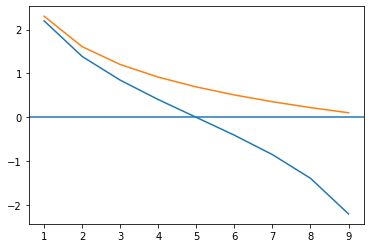

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

N = 10
dfList = np.arange(1, 10, 1)
plt.plot(dfList, [idf4(_) for _ in dfList])
plt.plot(dfList, [idf5(_) for _ in dfList])
plt.axhline(0)
plt.show()

## TF-IDF Weight Schemes
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Recommended tf–idf weighting schemes
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>document term weight
</th>
<th>query term weight
</th></tr>
<tr>
<td>1</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/74db3d91105b74e8450a78fadbf7ea7f241bc737" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:11.377ex; height:5.509ex;" alt="{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow>
          <mo>(</mo>
          <mrow>
            <mn>0.5</mn>
            <mo>+</mo>
            <mn>0.5</mn>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                    <mo>,</mo>
                    <mi>q</mi>
                  </mrow>
                </msub>
                <mrow>
                  <munder>
                    <mo movablelimits="true" form="prefix">max</mo>
                    <mrow class="MJX-TeXAtom-ORD">
                      <mi>t</mi>
                    </mrow>
                  </munder>
                  <msub>
                    <mi>f</mi>
                    <mrow class="MJX-TeXAtom-ORD">
                      <mi>t</mi>
                      <mo>,</mo>
                      <mi>q</mi>
                    </mrow>
                  </msub>
                </mrow>
              </mfrac>
            </mrow>
          </mrow>
          <mo>)</mo>
        </mrow>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fe1629098093a97eb293bd5085009c51c3cdd77b" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.671ex; width:29.854ex; height:6.509ex;" alt="{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}"/></span>
</td></tr>
<tr>
<td>2</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle 1+\log f_{t,d}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 1+\log f_{t,d}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/dc85c57525999f9f224ac5623e606bea2160d171" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:10.644ex; height:2.843ex;" alt="1+\log f_{{t,d}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow>
            <mn>1</mn>
            <mo>+</mo>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <mi>N</mi>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mfrac>
            </mrow>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/29f34f3a19a3fec371d5ab2756896a4c3cfc0d96" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:13.453ex; height:6.176ex;" alt="{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>3</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c271425fa07254a10379f1379e02d0fd034f4f21" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:20.548ex; height:5.509ex;" alt="{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>q</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cb8cdf7f351b63973cee045cc98c9efcde04203a" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:20.445ex; height:5.509ex;" alt="{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}"/></span>
</td></tr></tbody></table>
</div>

In [57]:
TWM = defaultdict(lambda: defaultdict(float))
DocLength = defaultdict(float)

for j, docs in TDM.items():
    try:
        IDF1 = idf1(len(docs))
        IDF2 = idf2(len(docs))
        IDF4 = idf4(len(docs))

        for i, f in docs.items():
            TF1 = tf1(f, sum(DTM[i].values()))
            TF2 = tf2(f)
            TF3 = tf3(f, max(DTM[i].values()))

            W1 = f*IDF1
            W2 = TF2*1
            W3 = TF2*IDF1
            W4 = TF3*IDF1

            TWM[j][i] = W4
            DocLength[i] += W4 ** 2
    except:
        continue

- Relvance = Similarity
- euclidean = sqrt(t ㅌ V (q - d_i)**2)
- cos theta = q vector * d_i vector / (|q| 굳이 계산 X) * |d_i|

In [58]:
kkma.nouns('가방 가방 가방')

['가방']

In [59]:
kkma.pos('가방 가방 가방')

[('가방', 'NNG'), ('가방', 'NNG'), ('가방', 'NNG')]

In [61]:
from math import sqrt

# Q = '필로폰 투약 혐의 로버트 할리, 최후 변론서 눈물 아들이 존경했는데'
# Q = '대통령 청와대 국민 정부'
Q = '아베 신조'
_Q = [_[0] for _ in kkma.pos(Q) if _[1].startswith('N') and _[0] in V]

QWM = defaultdict(float)

for t in _Q:
    j = V.index(t)
    QWM[j] += 1

maxFreq = max(QWM.values())

for j in QWM:
    IDF1 = idf1(len(TWM[j]))
    QWM[j] = tf3(QWM[j], maxFreq, 0.5) * idf1(len(TWM[j]))
    
QLength = sqrt(sum([_**2 for _ in QWM.values()]))

In [62]:
QWM

defaultdict(float, {2638: 2.302585092994046, 2639: 2.302585092994046})

In [63]:
searchResult = defaultdict(float)
for q_j, w_q in QWM.items():
    for i, w in TWM[q_j].items():
        searchResult[i] += q_j*i

for i, innerProduct in searchResult.items():
    searchResult[i] = innerProduct / (QLength * sqrt(DocLength[i]))

for _ in sorted(searchResult.items(), key=lambda x: x[1], reverse=True):
    print(_[1])
    print(collection[_[0]])
    print()

684.4971439126839
듀얼스크린 동시 작업게임에 유용갤폴드메이트X 대비 가격 절반LG전자의 첫 5G 스마트폰 V50 씽큐사진제공LG전자서울경제 미국 경제 매체 포브스가 LG전자066570의 최신 스마트폰 V50 씽큐에 대해 가장 현실적인 폴더블폰이라고 평가했다17일 포브스는 V50 씽큐 사용후기를 다룬 기사에서 삼성 갤럭시 폴드와 화웨이 메이트X 등의 출시가 연기된 상황에서 두 개의 스크린을 연결하는 LG V50 듀얼스크린이 가장 현실적인 선택지로 보인다며 1주일간 사용해본 결과 합리적인 가격으로 폴더블폰에서 기대할 수 있는 장점들을 충분히 갖췄다고 밝혔다포브스는 듀얼 스크린을 활용한 유용한 기능들도 소개했다 원본과 새로운 버전의 문서를 나란히 놓고 검토하거나 유튜브 동영상을 보면서 다른 화면에서 트위터를 할 수 있다고 전했다 듀얼 스크린을 게임 패드로 활용해 즐기는 방식도 다뤘다V50 씽큐의 가성비가격 대비 성능에도 높은점수를 줬다 포브스는 다른 폴더블폰이 2000달러약 235만원를 웃돌지만 V50 씽큐는 그 절반 수준이라며 저렴하고 내구성이 뛰어나다고 호평했다임진혁기자 com서울경제 바로가기 텔레그램으로 서울경제 구독하기   네이버TV로 서울경제썸 구독하기 네이버 메인에서 No 1 뉴스 서울경제를 만나보세요저작권자  서울경제 무단 전재 및 재배포 금지

327.29077367801386
아베 신조 일본 총리가 지난 3일 도쿄 일본기자클럽에서 열린 당수 토론회에서 물을 마시고 있다 도쿄AFP연합뉴스일본 정부가 한국을 겨냥한 수출 규제 조치를 두고 또다시 앞뒤가 안 맞는 행태를 보이고 있다 북한까지 끌어들여 한국의 전략물자 수출관리 문제를 흔들어대다가 한국 측 반격에 직면하자 맞지 않는 지적이라고 한국 탓을 하고 있다 지난 1일 기습적인 규제 조치 발표 이후 고삐 풀린 듯 공세를 펼치더니 뜻대로 되지 않자 한 발을 빼는 모습이다18일 일본 언론에 따르면 일본 정부는 수출 규제 조치가 안전보장상 수출관리 운용의 재검토로 대항조치가 아니라고 처음부터 일

In [64]:
searchResult = defaultdict(float)
for t in V:
    j = V.index(t)
    
    for i, w in TWM[j].items():
        searchResult[i] += w**2# (QWM[j] - w)**2

for i, innerProduct in searchResult.items():
    searchResult[i] = -sqrt(innerProduct)

for _ in sorted(searchResult.items(), key=lambda x: x[1], reverse=True):
    print(_[1], len(collection[_[0]].split()))
    print(collection[_[0]][:30])
    print()

-12.610209036107518 122
일본 불매 운동 포스터 사진온라인 커뮤니티국민의 자발적

-14.665573651889279 138
듀얼스크린 동시 작업게임에 유용갤폴드메이트X 대비 가격

-15.06218188488902 139
동영상 뉴스주영진의 뉴스브리핑인터뷰를 인용보도할 때는 

-15.330778869197601 207
제약바이오업계 숙원인 첨단 재생의료 및 첨단 바이오의약

-16.349925294847303 515
고민정 청와대 대변인 뉴시스청와대가 17일 한국을 겨냥

-16.349925294847303 515
고민정 청와대 대변인 뉴시스청와대가 17일 한국을 겨냥

-16.406164260451636 298
스틸웰 국무부 차관보 한일 관계 개선 희망 언급문제 해

-16.973316196120066 265
17일 표창원 의원 이어 피고발인 신분으로 출석CBS노

-17.20580272886454 250
근로감독 결과 갈 길 먼 드라마 제작현장게티이미지뱅크K

-17.387702776791805 240
조선DB남편을 청부살해하고 강도 사건으로 위장한 혐의로

-18.14731363551138 221
머니투데이 김수현 기자 1위 베이조스에 이어 2위 아르

-18.452321271414498 362
회견서 밝혀윤순구 스틸웰 대화재개 통한 한일갈등 해결 

-19.09987795565578 293
정부가 민간택지에서 짓는 아파트에 대해 분양가 상한제 

-19.128784832900013 220
일진복합소재 매연저감장치DPF 사진일진복합소재일진복합소

-19.594773407288592 334
합동참모본부는 17일 오전 충남 당진 서해안고속도로 행

-19.995348504926497 299
17일 하현회 LG유플러스 부회장이 서울 용산구 LG유

-20.08854558305544 301
식용 곤충 고소애가 암 수술 환자의 영양상태 개선과 면

-20.370432030373475 327
코르셋 한복으로 논란 겪은 2019 미스코리아 선발대